# Indiegogo Research Data
* Rui Bin, 2022

Aims:  
* Find baseline rate of giving on a weekly and daily basis
* Find time and day which have the most contributions
* Graph campaign trajectory

 # Set up
 First set up the tables as dataframes

In [1]:
from pandas import read_csv, DataFrame
import pandas as pd

campaigns_details_raw_df = read_csv("campaigns_details.csv")
campaign_snapshots_raw_df = read_csv("campaign_snapshots.csv")

campaign_snapshots_raw_df['timestamp'] = pd.to_datetime(
    campaign_snapshots_raw_df['timestamp'],
    format="%Y-%m-%d %H:%M"
)
campaign_snapshots_raw_df = campaign_snapshots_raw_df.set_index('timestamp')
campaigns_details_raw_df = campaigns_details_raw_df.set_index('project_id')

Extend a column for total funds raised and adjusted total funds raised in campaigns_details

    Working with the assumption that amount less than 150 are refunded. So any amount more than that is likely to be a successful campaign
    Note that we have not accounted for currency difference and there will be false positives

Create a dict / dataframe for tags with their contributions count and funds raised
  sorted by contributions count, then funds_raised_adjusted and funds_raised_amount 
  
Contributions count, with a resolution of 10 minutes, is useful as a proxy for funds raised and amount of people reached. 

The below section will demostrate any correlations between contributions count and funds raised.

In [2]:
import ast

funds_raised_list = []
tags_dict = {}
for campaign_id, row in campaigns_details_raw_df.iterrows():
    # Get the snapshot for a given campaign
    campaign_snapshot = \
      campaign_snapshots_raw_df.query(f'`project_id` == {campaign_id}')
    funds_raised = campaign_snapshot['funds_raised_amount'][-1]
    funds_raised_adjusted = 0
    if funds_raised >= 150:
        funds_raised_adjusted = funds_raised
    # Filter to only funds change with more than 0
    contributions_count = \
      campaign_snapshot.query(f'`funds raised delta` > 0 ')\
        ['funds raised delta'].count()
    funds_raised_list.append(
        {
        'project_id' : campaign_id,
        'funds_raised_amount' : funds_raised,
        'funds_raised_adjusted' : funds_raised_adjusted,
        'contributions_count' : contributions_count,
        }
    )
    campaign_tags = ast.literal_eval(row['tags'])
    for tag in campaign_tags:
        tags_funds_raised = funds_raised
        tags_funds_adjusted = funds_raised_adjusted
        tags_contributions_count = contributions_count
        try:
            if tags_dict[tag]:
                tags_funds_raised += tags_dict[tag]['funds_raised_amount']
                tags_funds_adjusted += tags_dict[tag]['funds_raised_adjusted']
                tags_contributions_count += tags_dict[tag]['contributions_count']
        except KeyError:
            pass
        tags_dict[tag] = {
            'funds_raised_amount' : tags_funds_raised,
            'funds_raised_adjusted' : tags_funds_adjusted,
            'contributions_count' : tags_contributions_count
        }
    

funds_raised_df = pd.DataFrame(funds_raised_list).set_index('project_id')
print(f"Number of tags: {len(tags_dict)}")
tags_df = pd.DataFrame(tags_dict.values(), index=tags_dict.keys())\
    .sort_values(by=['contributions_count', 'funds_raised_adjusted', \
                     'funds_raised_amount'], ascending=False)



# print(len(funds_raised_df))
# print(len(campaigns_details_raw_df))

campaigns_details_df = pd.concat([campaigns_details_raw_df, funds_raised_df], axis=1)
print(f'Number of campaigns: {len(campaigns_details_df)}')
# Verify that sum of funds raised is accurate
# display(campaigns_details_df.query('tags.str.contains("community")', engine='python')['funds_raised_amount'].sum())


Number of tags: 107
Number of campaigns: 534


Convert close_date and open_date to datetime format

Allows us to query by open and closing date of the campaigns. We want to filter for campaigns that took place entirely within the main observation period. 2022-01-01 to 2022-04-15 

In [3]:
from datetime import datetime

campaigns_details_df['close_date'] =  pd.to_datetime(
    campaigns_details_df['close_date'], format='%Y-%m-%d', utc=True).dt.date
campaigns_details_df['open_date'] =  pd.to_datetime(
    campaigns_details_df['open_date'], format='%Y-%m-%d', utc=True).dt.date


# Top 25 tags by contributions count and funds_raised_adjusted

> Note both columnns of funds_raised have not accounted for difference in currency as all funds are
in local currency units

In [4]:
display(tags_df.head(25))

,funds_raised_amount,funds_raised_adjusted,contributions_count
community,4168607,4165520,6498
female founders,541590,540976,1841
family,381876,381032,1622
food,375345,374650,1422
women,258577,257825,1404
social innovations,656524,655766,1011
kids,145460,144893,838
restaurant,179437,179235,712
first-time founders,260049,259793,699
garden,147579,147554,623


# Checking for correlation between top_6_count, contributions_count and funds_raised_amount

## Filtering campaigns which raised less than 150
Check for campaigns that raised more than 150 (Our arbitary cut off for determining campaign success).

Most of the campaigns remaining after the filter should have money raised.
Conversly, most of the campaigns that are filtered **out** should show $0 raised as the money are refunded.

There are some false positives, i.e. actually not funded and filtered out but its a neglible amount and false negative, actually funded but not filtered out. The rate of false negatives are 1 / 31 projects in projects with the "community" tag, sampled from campaigns with funds_raised < 200 and lifetime is within the sampling period.

If the funds_raised_amount is more than 150, then when we check the campaign, it should show close to the amount raised.  
  
Generally the amount of contributions is +/- 5 of the amount of backers on a campaign.



In [5]:
campaigns_details_df.query(
    'tags.str.contains("community")', engine='python')\
    .loc[campaigns_details_df['close_date'] < datetime.strptime('2022-04-15', "%Y-%m-%d").date()]\
    .loc[campaigns_details_df['open_date'] > datetime.strptime('2021-12-31', "%Y-%m-%d").date()]\
    .query('`funds_raised_amount` < 200')[
    [
        'title(s)', 'tagline(s)',
        'top 6 count', 'currency',
        'funds_raised_amount', 'funds_raised_adjusted', 
        'contributions_count',
        'open_date', 'close_date', 'tags'
    ]
].sample(10, random_state=1325834067)
# Random seed to "show the same samples as the one i used"

,title(s),tagline(s),top 6 count,currency,funds_raised_amount,funds_raised_adjusted,contributions_count,open_date,close_date,tags
project_id,,,,,,,,,,
2731434,['Help Azi create content with a new PC!'],['Help a streamer in need replace their failin...,0,USD,100,0,0,2022-01-28,2022-03-30,"['community', 'computers']"
2739084,['STOP WAR IN UKRAINE'],['I Raising money to help people affected by t...,0,PLN,10,0,0,2022-03-01,2022-03-12,"['safety', 'community', 'family']"
2732188,['Karaberd House: Phase IV'],['Join the community and claim your spot'],0,USD,100,0,0,2022-02-10,2022-04-12,"['community', 'hiking', 'camping', 'adventure']"
2726295,['medical & funeral expenses and care for da...,['I am raising funding for my friend who lost...,31,USD,175,175,1,2022-01-09,2022-02-10,"['family', 'love', 'other', 'community', 'firs..."
2733910,['MoboShop Retail Container'],['Mobilizing Small Business'],41,USD,180,180,3,2022-02-12,2022-03-30,"['community', 'professional', 'other']"
2729035,['Traditional Aradian Medicine & Queer Communi...,['Raising funds to study Aradian medicine of ...,0,GBP,80,0,6,2022-01-17,2022-03-19,"['community', 'lgbtq', 'books']"
2689410,['Gaybors Spaces Los Angeles'],['A dedicated safe space for the LGBTQ+ commun...,16,USD,150,150,1,2022-02-22,2022-03-25,"['lgbtq', 'community', 'professional', 'youtub..."
2727403,['Sponsor my book on healing from trauma and a...,"['Healing the world, one page at a time.']",45,USD,160,160,11,2022-01-08,2022-02-09,"['love', 'community', 'family', 'female founde..."
2729400,['Enviro Crew of Old Ottawa South'],['Light up the marquee at the Mayfair in suppo...,8,CAD,25,0,0,2022-01-17,2022-02-01,['community']


## Create scatter plot of top 6 count, funds_raised_adjusted, contributions_count  

First step is plotting only those which have funds_raised_adjusted > 0  
meaning, these campaigns are likely to have raised funds

406

0.5864

0.12595

0.02433

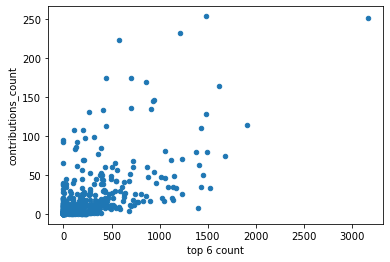

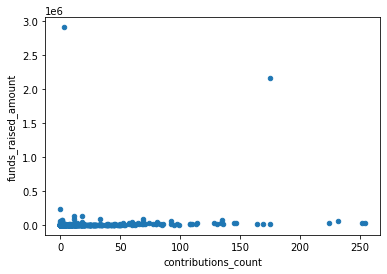

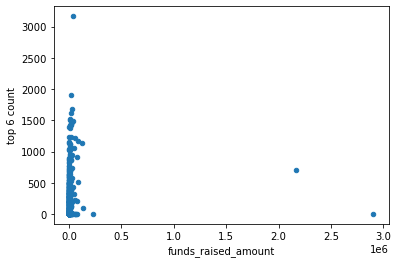

In [6]:
%matplotlib inline


filtered_campaigns = campaigns_details_df\
    .query('`funds_raised_adjusted` > 0')\
    .sort_values(by=['top 6 count'], ascending=False)\
    [['title(s)', 'top 6 count', 
      'contributions_count', 'funds_raised_amount', 
      'currency', 'tags',
      'open_date', 'close_date']]

display(len(filtered_campaigns))
filtered_campaigns.plot.scatter(x='top 6 count', y='contributions_count')
display(round(filtered_campaigns['top 6 count'].corr(filtered_campaigns['contributions_count']), 5))

filtered_campaigns.plot.scatter(x='contributions_count', y='funds_raised_amount')
display(round(filtered_campaigns['contributions_count'].corr(filtered_campaigns['funds_raised_amount']), 5))

filtered_campaigns.plot.scatter(x='funds_raised_amount', y='top 6 count')
display(round(filtered_campaigns['funds_raised_amount'].corr(filtered_campaigns['top 6 count']), 5))

### Filter for campaigns that lifetime was within collection period

clean start and end date


144

0.56801

0.28574

0.09453

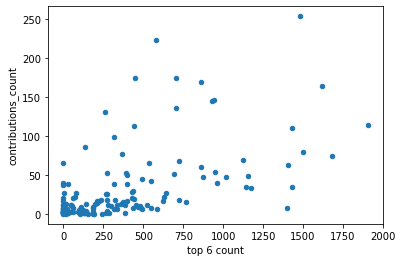

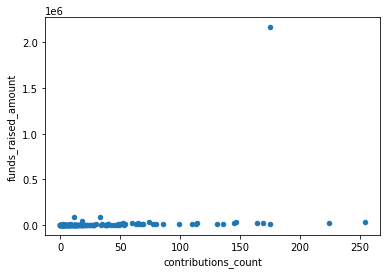

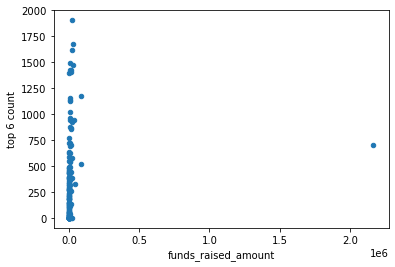

In [7]:
print("clean start and end date")
filtered_campaigns = filtered_campaigns\
    .loc[campaigns_details_df['close_date'] < datetime.strptime('2022-04-15', "%Y-%m-%d").date()]\
    .loc[campaigns_details_df['open_date'] > datetime.strptime('2021-12-31', "%Y-%m-%d").date()]

display(len(filtered_campaigns))
filtered_campaigns.plot.scatter(x='top 6 count', y='contributions_count')
display(round(filtered_campaigns['top 6 count'].corr(filtered_campaigns['contributions_count']), 5))

filtered_campaigns.plot.scatter(x='contributions_count', y='funds_raised_amount')
display(round(filtered_campaigns['contributions_count'].corr(filtered_campaigns['funds_raised_amount']), 5))

filtered_campaigns.plot.scatter(x='funds_raised_amount', y='top 6 count')
display(round(filtered_campaigns['funds_raised_amount'].corr(filtered_campaigns['top 6 count']), 5))


### Filter for campaigns that are USD only

Shows all currencies and their number of campaigns

In [8]:
filtered_campaigns['currency'].value_counts()

USD    105
EUR     15
AUD      5
GBP      5
CAD      5
HKD      3
JPY      2
PLN      2
MXN      1
SGD      1
Name: currency, dtype: int64

clean currency to USD only


105

0.57443

0.83354

0.622

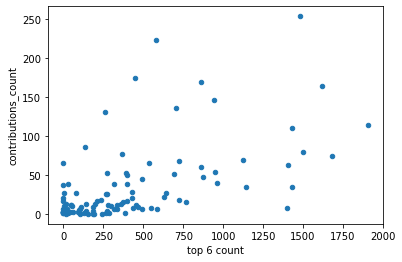

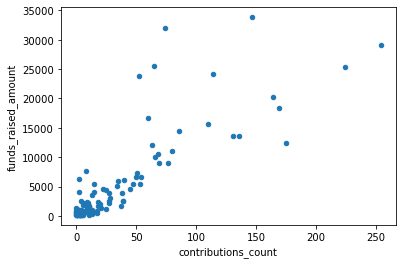

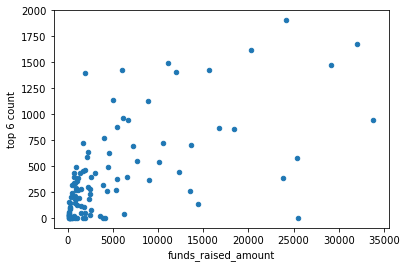

In [9]:
print("clean currency to USD only")
filtered_campaigns = filtered_campaigns.query('`currency` == "USD"')

display(len(filtered_campaigns))
filtered_campaigns.plot.scatter(x='top 6 count', y='contributions_count')
display(round(filtered_campaigns['top 6 count'].corr(filtered_campaigns['contributions_count']), 5))

filtered_campaigns.plot.scatter(x='contributions_count', y='funds_raised_amount')
display(round(filtered_campaigns['contributions_count'].corr(filtered_campaigns['funds_raised_amount']), 5))

filtered_campaigns.plot.scatter(x='funds_raised_amount', y='top 6 count')
display(round(filtered_campaigns['funds_raised_amount'].corr(filtered_campaigns['top 6 count']), 5))

Sample 10 campaigns randomly  
Filter to tags containing "family" first as this is one of the highest ranking tags relevant to our project
We will use these campaigns to analyse the difference in funds raised and contributions count and subsequently how it relates to top 6 count.

In [10]:
filtered_campaigns.query('tags.str.contains("family")', engine='python').sample(10, random_state=0x13512a)

,title(s),top 6 count,contributions_count,funds_raised_amount,currency,tags,open_date,close_date
project_id,,,,,,,,
2726295,['medical & funeral expenses and care for da...,31,1,175,USD,"['family', 'love', 'other', 'community', 'firs...",2022-01-09,2022-02-10
2695433,"[""Let's Play Work: A Grown-Up Friendly Kid Spa...",76,27,2570,USD,"['kids', 'community', 'family', 'female founde...",2022-01-04,2022-02-19
2738141,['Help Our Friends Survive The Crisis in Ukrai...,945,147,33802,USD,"['safety', 'security', 'clothing', 'community'...",2022-02-25,2022-03-11
2735791,['3 Bros Running Company'],431,28,3005,USD,"['community', 'family', 'festival', 'sports', ...",2022-02-17,2022-04-04
2731837,['Derby Coffee Roasters - Durham HQ'],399,50,6606,USD,"['coffee', 'community', 'family']",2022-02-14,2022-03-18
2738513,['Help my family to escape from the War in Ukr...,373,15,5413,USD,"['family', 'food', 'safety', 'security', 'kids']",2022-02-27,2022-03-30
2734690,['Learning Through Play'],0,2,300,USD,"['kids', 'community', 'family', 'babies', 'soc...",2022-02-13,2022-03-24
2736193,['Tare Market #2: Bringing Zero Waste to More ...,261,131,13522,USD,"['coffee', 'community', 'dogs', 'family', 'fem...",2022-02-23,2022-03-31
2733767,['AMERICAN MOTHERS: A LOVE STORY'],0,3,229,USD,"['women', 'family', 'community']",2022-02-09,2022-03-27


Sample campaigns with 
> 25 >= contributions_count <= 60 and
> funds_raised_amount < 2500

Here I try to slice a section of the campaigns with similar contributions count and funds raised to find out why their top 6 count differs. 

In [11]:
filtered_campaigns.query(\
    'contributions_count <= 40 and ' + \
    'funds_raised_amount < 2500')


,title(s),top 6 count,contributions_count,funds_raised_amount,currency,tags,open_date,close_date
project_id,,,,,,,,
2711720,['Heartleaf Book Co-op'],1399,7,1900,USD,"['books', 'community', 'female founders', 'lgb...",2022-01-06,2022-02-16
2730475,['Titan Cards: Year Two'],722,18,1685,USD,"['youtube', 'community']",2022-01-28,2022-02-28
2733079,['The White Bear. Bringing Stories of Traditio...,639,27,2260,USD,"['documentary', 'short film', 'translation', '...",2022-02-05,2022-03-26
2728410,['openHAUS expansion to 2nd Location'],587,6,2176,USD,['community'],2022-02-02,2022-04-04
2726712,['Neds Big Billboard Adventure'],492,6,900,USD,['first-time founders'],2022-01-04,2022-03-06
2726158,['Help for Armenian Family in Beirut'],466,9,1890,USD,['community'],2022-01-01,2022-01-16
2743398,['Ukraine Crisis Relief Fund'],451,11,1660,USD,"['food', 'clothing', 'kids', 'family', 'other']",2022-03-19,2022-03-25
2733849,['Rebuild Homes in Haiti - THE FINAL PUSH'],435,8,765,USD,"['community', 'family', 'kids', 'safety', 'sle...",2022-02-07,2022-02-15
2730365,['A Celebration of Life Energy for Clifford Ma...,432,21,1330,USD,"['community', 'family', 'love']",2022-01-22,2022-03-24


## Old code

Extract all cells with a fund raised delta and put in a new dataframe

Create buckets for days of the week and time of the day

In [ ]:
contributions_df = campaign_snapshots_df.query('`funds raised delta` > 0 & `funds raised delta` < 1000')

contributions_df.index.max() - contributions_df.index.min()

contributions_df.groupby(
    [contributions_df.index.day_of_week])['funds raised delta'].sum()

In [ ]:
contributions_df.groupby(
    [contributions_df.index.hour])['funds raised delta'].sum()

In [ ]:
contributions_df.groupby(
    [contributions_df.index.weekofyear])['funds raised delta'].mean()


In [ ]:
contributions_df.groupby(
    [pd.Int64Index(contributions_df).index.isocalendar().weekofyear]
)['funds raised delta'].mean()